# scikit-learnによるサポートベクトルマシン分類(SVC)とサポートベクトル回帰(SVR)

<div style="text-align: right;">
    <a href="svc_svm_in_scikit-learn.ipynb">このページのオリジナルのipynbファイル</a>
    <a href="index.html">トップページへ</a>
</div>

## 前置き

本講義では、説明変数$x$と目的変数$y$の関係の推定（回帰）問題を扱っている。

これまでは、その関係を、

$$
y = \sum_{i=1}^M w_i \phi_i(x)
$$

のように、説明変数(*)の関数を$M$個用意して、その線形結合で目的変数を表すという形に持ち込むと、$M$個の重回帰と同じ形式で扱えること、それをベイズ的な考え方で扱うと、誤差分布に関する見通しが良くなることを学んだ。

説明変数の関数の組$\{\phi_i (x)\ | \ i=1,\cdots,M \}$は、基底関数と呼ばれた。

ここでは基底関数を選ばなくても、データ自体からもっともらしい推定値とその周りの分散が求められる方法(カーネル法)を紹介する。

まずは、その代表的な例であるサポートベクトル回帰(SVR)を扱う。

サポートベクトルの考え方はもともとは、回帰と並ぶ機械学習のもう一つの課題である「分類」(classification)の手法として考案されたものである。

<span class="burk">SVRの特徴(単純な回帰にくらべ進化した点)は以下の２点に要約できる。</span>
- <span class="burk">カーネル法の一つである</span>
- <span class="burk">回帰問題の評価関数にSVCの考え方を応用</span>

回帰を扱う前に、分類の手法としての「サポートベクトルマシン」(SVM)について述べる。

## サポートベクトルマシン概説


別のノートで説明する。[こちら](http://toyoki-lab.ee.yamanashi.ac.jp/~toyoki/lectures/simulationMethods/svc_note.html)

scikit-learn's user guide: https://scikit-learn.org/stable/modules/svm.html#svm



## skitlearnにおけるサポートベクトルマシンの利用例

[「Ipythonデータサイエンスクックブック 第2版」](https://www.oreilly.co.jp/books/9784873118543/)という書籍に載っている例でsvmの振る舞いをみてみよう。

原文はgithubのサイトで公開されている。


第８章「機械学習」レシピ8.5 https://ipython-books.github.io/85-using-support-vector-machines-for-classification-tasks/

以下の英語の部分は、この書籍の原著からの引用である。


### 訓練データ (1)

平面上に1か0の値を持つ点が分布している場合について、1と0の領域の境界線をみつける。（境界領域では両者が混在しているデータを扱う。）

> 2. We generate 2D points and assign a binary label according to a linear operation on the coordinates.

$x + y >1$のときtrue, それ以外はfalseになる$200\times 200$の2次元データyを作る。 [スクリプトに関するコメント](comments_python_scripts.html#numpy1)

２つの説明変数$x$, $y$に対して、目的変数$z$が対応すると考える。下図では面に$(x,y)$の値を、面に垂直方向に$z$があると想像してほしい。$z$の値は今の場合はTrueあるいはFalseであり、図では濃い青と薄い青で示している。

プログラム内では、Xが平面内の位置データ（２次元配列）、yはtrue/falseのどちらかを取る。

境界線は$y = -x + 1 $とした。

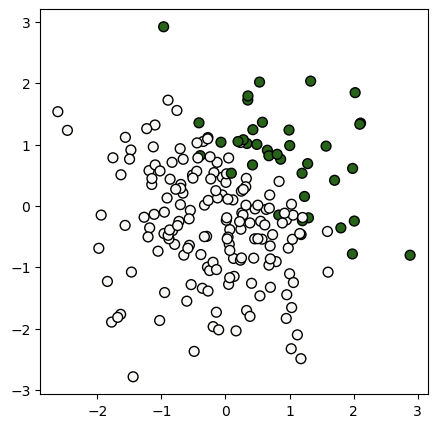

In [29]:
# サンプルデータの作製

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 平面上で適当に200個の点を選ぶ 座標値(x,y)の200個の組 X[200,2]
X = np.random.randn(200, 2)
# ターゲットt[x[i],y[i]]の値を x[i]+ y[i] > 1 のときtrue, それ以外 false => それデータとしてtrue or falseの境界をsvcで見つける
# 右辺の評価式がtrueかfalseかを配列としてyに与える (ここでは200個の一次元は配列)
y = X[:, 0] + X[:, 1] > 1

# 位置をランダムに動かす: 練習として試してみよう
noise = (np.random.rand(200,2)-0.5)*1.0
X = X + noise

# We display the points with their true labels.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmap = plt.cm.PiYG # Blues
ax.scatter(X[:, 0], X[:, 1],
           s=50, c=.5 + .5 * y, # c, edgecolorは色指定, cmapは色調の指定
           edgecolors='k',
           lw=1, cmap=cmap,
           vmin=0, vmax=1)

### サポートベクトル識別 (1) 線形

> 3. We now fit a linear **Support Vector Classifier** (SVC). This classifier tries to separate the two groups of points with a linear boundary (a line here, more generally a hyperplane).

 - 線形識別機の用意　(LinearSVC関数の利用)
 - データ(X,y)によりトレーニング(fit関数)
 
 原著では、svm.LinearSVCが用いられているが、ここでは、サポートベクトルのデータ点を明示できるsvm.SVC(kernel='linear')を用いてみる。

In [30]:
import sklearn.svm as svm
# We train the classifier.
#est = svm.LinearSVC()
est = svm.SVC(kernel='linear')
est.fit(X, y); # サポートベクトルマシーンに学習させる

識別実行のための関数定義

> 4. We define a function that displays the boundaries and decision function of a trained classifier.

 - ２次元面のメッシュ (xx, yy) を作成し、メッシュ上のすべての点について境界のどちらかを判定 (decision_function)
  - 返り値をZ (「高さ」）に代入
 - Zの値をグラデーションで表示 (imshow関数の部分)
 - 境界 (Z(x,y)=0)の線を引く

In [33]:
# We generate a grid in the square [-3,3 ]^2.
xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))

# This function takes a SVM estimator as input.

def plot_decision_function(est, title):
    # evaluate the decision function on the grid.
    Z = est.decision_function(np.c_[xx.ravel(),
                                    yy.ravel()])
    Z = Z.reshape(xx.shape)
    cmap = plt.cm.PiYG # Blues

    # We display the decision function on the grid.
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(Z,
             extent=(xx.min(), xx.max(),
                     yy.min(), yy.max()),
             aspect='auto',
             origin='lower',
             cmap=cmap)

    # We display the boundaries.
    ax.contour(xx, yy, Z, levels=[0],
               linewidths=2,
               colors='k')

    # We display the points with their true labels.
    ax.scatter(X[:, 0], X[:, 1],
               s=50, c=.5 + .5 * y,
               edgecolors='k',
               lw=1, cmap=cmap,
               vmin=0, vmax=1)
    ax.axhline(0, color='k', ls='--')
    ax.axvline(0, color='k', ls='--')
    ax.axis([-3, 3, -3, 3])
    ax.set_axis_off()
    ax.set_title(title)
    ax.scatter(est.support_vectors_[:,0], est.support_vectors_[:,1],
                facecolors='none', edgecolors='r',s=30)
    # 注："support_vectors_"にサポートベクトルに該当するデータが入っている

> 5. Let's take a look at the classification results with the linear SVC.

識別の実行と図示

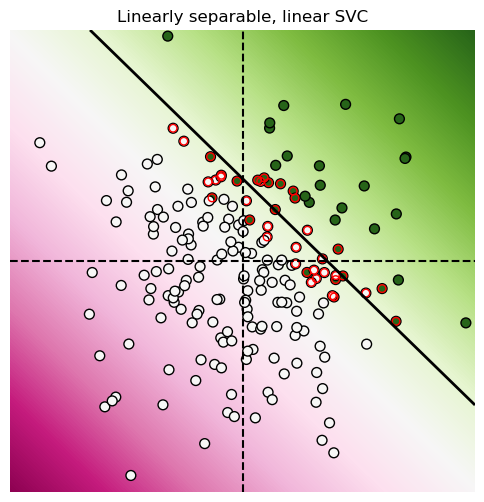

In [34]:
ax = plot_decision_function(
    est, "Linearly separable, linear SVC")

The linear SVC tried to separate the points with a line and it did a pretty good job.

( **The red circles indicate support vectors.** )

**[学習]**

$x + y> a$ ($a$はデータが２分類できるように、$-2<a<2$程度の範囲で変えて試してみよう。 

余裕があれば、

- numpyのメソッド meshgrid, ravel, c_
- matplotlibのimshow, contour

について調べてみよう。




### 訓練データ(2) 線形な境界を引けない場合

> 6. We now modify the labels with a *XOR* function. A point's label is 1 if the coordinates have different signs. This classification is not linearly separable. Therefore, a linear SVC fails completely.

１，３象限はtrue, ２、４象限はfalseとなるデータを作成し、線形識別してみる。

ここでは、SVMのハイパーパラメータをグリッドサーチ（しらみつぶし探索）GridSearchCVによって良いものを選んでいる。（ここではそれには立ち入らない）

うまくいかないという警告が多数出力される！が、つぎのような結果になるだろう。試してみてほしい。

![svc_nogood_linear](images/svc_linear_nogood.png)


In [ ]:
import sklearn.model_selection as ms

y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0) # 第１象限と第３象限のみfalse

# We train the classifier.
est = ms.GridSearchCV(svm.LinearSVC(),
                      {'C': np.logspace(-3., 3., 10)})
est.fit(X, y)
print("Score: {0:.1f}".format(
      ms.cross_val_score(est, X, y).mean()))

# We plot the decision function.
ax = plot_decision_function(
    est, "XOR, linear SVC")



これは、直線による区分は、当然だが、できないことを意味する。（収束しない！）

そこでSVRが登場するのだが、基本的なロジックは

1. これまでに用いてきたの同様に、線形分類で切るように、ある非線形関数（基底）により変換する。
2. そのような基底を見つけるのは一般には困難であるが、それは「カーネルトリック」と呼ばれる巧妙な方法で解決できる。

この部分は[別のノート](svc_note.html)で述べる。


### 非線形変換を含む識別機 (カーネル法の導入)

SVMでは、カーネルを用いて分類線（境界）を計算することができる。

データ${\bf x}$ に対する非線形関数$\{{\bf\phi}_1, {\bf\phi}_2, \cdots, {\bf\phi}_M\}$を用意し、
$$
y({\bf x}) = {\bf w}^T {\bf \phi}({\bf x}) +b
$$
のような、目標変数と説明変数の間に非線形な関係があるとし、係数${\bf w} = (w_1, w_2, \cdots, w_M)^T$を学習により求める。

この問題は、$k({\bf x},{\bf x'})= {\bf \phi} ({\bf x})^T{\bf \phi} ({\bf x}')$で定義されるカーネルを用いて

$$
 y({\bf x}) = \sum_{n=1}^{N} a_n t_n k({\bf x}, {\bf x_n}) + b
$$

の形式に変換できることが知られている。ここで$t_n$は訓練データ${\bf x_n}$に対する目標値であり、$a_n$は学習により求める係数である。

ここからは、${\bf \phi}$からカーネル$k({\bf x},{\bf x'})$を作ったことは**忘れることにする。**

つまり、<span class="mark">、非線形関数${\bf \phi}$を設定するのではなく、カーネル$k({\bf x},{\bf x'})$自体に何らかの関数を指定することにより識別学習を行えることである。（逆に言えば関数${\bf \phi}$はどのようなものかわからない。）</span> [^1]

Scikit-learnのSVCでは、カーネルとしては標準的に<span class="mark">ガウシアン放射基底関数(Gaussian Radial Basis Function)</span>が用いられている。この置き換えは**kernel trick**と呼ばれる。

$$
k({\bf x},{\bf x'}) = \exp ( -\gamma || {\bf x}-{\bf x'} ||^2)
$$

が用いられる。

RBFカーネルに含まれるパラメータ$\gamma$の値をどう選ぶかは重要である。これは利用者が与える必要がある（このようなパラメータは**ハイパーパラメータ**と呼ばれる）。ここでは**グリッドサーチ**を使って最適なものを探す。後の節で述べるように、実際のデータでは**交差検定**を用いて最適なものを選ぶことがよく行われる。

> The $\phi$ function does not need to be computed explicitly. This is the kernel trick; it suffices to know the kernel $k(x,x')$. The existence of a function $\phi$ corresponding to a given kernel $k(x, x')$ is guaranteed by a mathematical theorem in functional analysis (Mercer's theorem).


> 7.  Fortunately, it is possible to use nonlinear SVCs by using **nonlinear kernels**. Kernels specify a nonlinear transformation of the points into a higher dimensional space. Transformed points in this space are assumed to be more linearly separable. By default, the **SVC** classifier in scikit-learn uses the **Radial Basis Function (RBF)** kernel:

"nonlinear transformation of the points into a higher dimensional space"とうところが理解しにくいところであるが、この比喩的表現を使わずに、生の数学的記述を学習するのが良いだろう。（線形の場合は、各データ点の境界線からの最短距離を評価に用いたが、これを曲がりくねった境界全体からの離れ具合をカーネルを通じて評価することを行っている。）

少し立ち入った説明は[こちら](https://8tops.yamanashi.ac.jp/~toyoki/lectures/simulationMethods/svr_note.html)

【注】
[^1]: カーネル法について、平井のテキストではCoverの言葉を引用して「『線形分離可能でない学習データは、非線形変換で高次特徴空間へ写像することにより線形分離可能となる可能性がある』という予測を頼りに、非線形写像を考えることにする」として説明を始めている。(「初めてのパターン認識」平井有三、森北出版 p.121)

<div name="svc_with_kernel"></div>

Score: 0.920


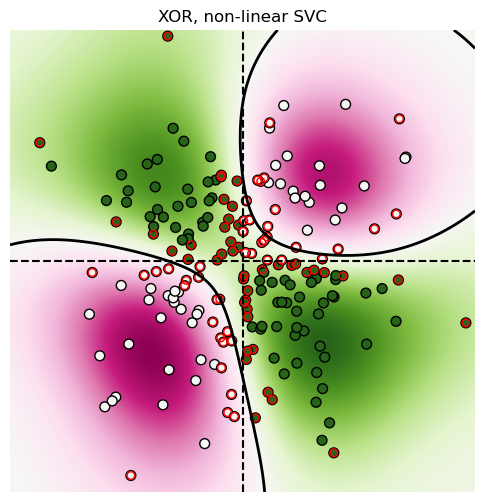

In [36]:
import sklearn.model_selection as ms

y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# determine the hyper-parameters C and gamma, and then create the SVM machine object with the optimal parameters
#est = ms.GridSearchCV(
#    svm.SVC(), {'C': np.logspace(-3., 3., 10),
#                'gamma': np.logspace(-3., 3., 10)})
est = svm.SVC(kernel="rbf")
est.fit(X, y)
print("Score: {0:.3f}".format(
      ms.cross_val_score(est, X, y).mean()))

#plot_decision_function(
#    est.best_estimator_, "XOR, non-linear SVC")
plot_decision_function(
    est, "XOR, non-linear SVC")

> This time, the non-linear SVC does a pretty good job at classifying these non-linearly separable points.

境界からの離れ具合は青色のグラデーションで表示されている。

**[練習]**

最初の訓練データを作り変えてSVCの性能を試してみよう。

## 回帰問題に対するサポートベクトルマシンの利用 (SVR: Support Vector Regression)

分類のためのSVMは、逆に、境界領域にたくさんのデータがあり、境界線より離れたところに少ないデータが存在する場合を想定すると、境界線が回帰線に対応する。そのことを積極的に使ったのがサポートベクトル(マシン)回帰(SVR)である。若干の数理的ノートは[こちら](https://toyoki-lab.ee.yamanashi.ac.jp/~toyoki/lectures/PracDataSci/svr_note.html)

例によって、つぎのような、sin関数にノイズを載せたデータを用いる。


In [51]:
# データ作成用関数 (randomnessはノイズの大きさ)
import random
def make_data_by_sin_gaussian(x, randomness=0.3):
    # y=sin (x)を計算し、ガウス分布に従うノイズを加える
    y = np.sin(x)
    e = [random.gauss(0, randomness) for i in range(len(y))]
    # e = np.random.randn(len(x))*0.2
    y += e
    return y


### scikit-learn所収のSVRの利用

scikit-learnに含まれているSVR藻じゅーうるを利用するのはいたって簡単で、包括的なモジュールsvmを読み込みその中のメソッドSVRの引数としてデータを与えるだけであり、基本的には今までの回帰メソッドと同様である。

データの範囲を越えた予測は困難だが、無難な値に収まっている。（基底関数を多項式にとったリッジ回帰などと比べてみてほしい。）

[pythonスクリプトに関するコメント](comments_python_scripts.html#numpy2)

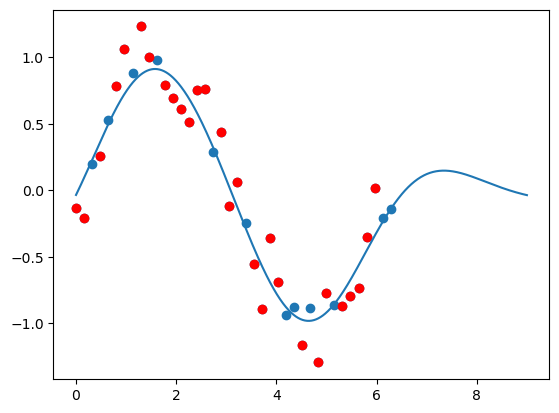

In [52]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import svm

x_max = 9.  # 予測の範囲の上限

# トレーニングデータ作成
n_tr = 40
x = np.linspace(0., np.pi*2., n_tr) # リスト 0から２πまでをn_tr等分した値を一次元配列
y = make_data_by_sin_gaussian(x, 0.2) # 第2引数は乗せるノイズの大きさ
X = x[:, np.newaxis]
   
# 学習を行う
svr = svm.SVR(kernel='rbf')
svr.fit(X, y)
  
# テストデータとして説明変数(x_test)を[0,x_max]の範囲の1000の点を用意し、推定値を計算し(結果はy_test)、
# 回帰曲線(x_test,y_test)を描く
x_test = np.linspace(0, x_max, 1000)
y_test = svr.predict(x_test[:, np.newaxis])
    
#グラフにプロットする。
plt.scatter(x, y)
plt.plot(x_test, y_test)
# サポートベクトルの表示（データポイントに赤で上書き）
plt.scatter(X[svr.support_], y[svr.support_], c="red") 
plt.show()
# print(X)

上の出力では、サポートベクトルであるデータを赤色で表示した。

推定の計算はデータの周辺部分（サポートベクトル）について行われる。サポートベクトルがデータ全体の数に比べて少なければ（疎（スパース）であるという）、計算時間の節約になる。これがSVRの利点である。

## Exercise 5

次のようなsinc関数にノイズを加えたデータについてSVRでの推定曲線を描いてみよう。

時間があればハイパーパラメータをいろいろ調整することや、参考に載せたRidge回帰やRVR(Relevance Vector Regression)も試してみよう。



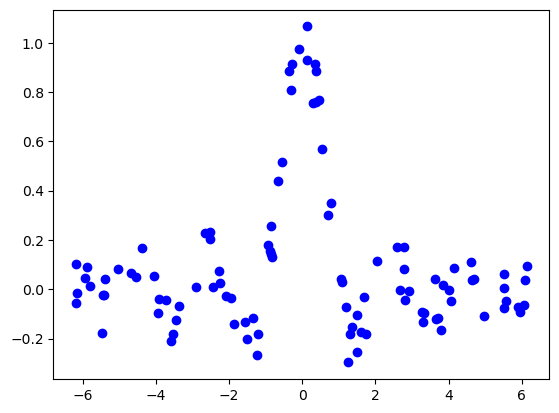

In [41]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(8)
rng = np.random.RandomState(0)

# Generate sample data
X = 4 * np.pi * np.random.random(100) - 2 * np.pi
y = np.sinc(X)
y += 0.25 * (0.5 - rng.rand(X.shape[0]))  # add noise

# X = X[:, None]

plt.plot(X, y, "bo")

## (参考) skitlearnのカーネルリッジ回帰

内部のアルゴリズムは筆者にはわからないが、scikit-learnにはリッジ回帰のカーネル版があるようだ。

これの利用では、基底関数を選ぶのではなく、カーネルを選択する。標準はrbf(Radial Basis Function)カーネルである。

以下は、その利用例である。

なお、SVRとKernelRidgeの比較は、

https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-ridge-regression-py

にある。

(注)

このページにあるように、一般にはハイパーパラメータをいろいろ試して最適な値にするために「虱潰し」に探索する（交差検定）を行うGridSearchCVがよく利用される。

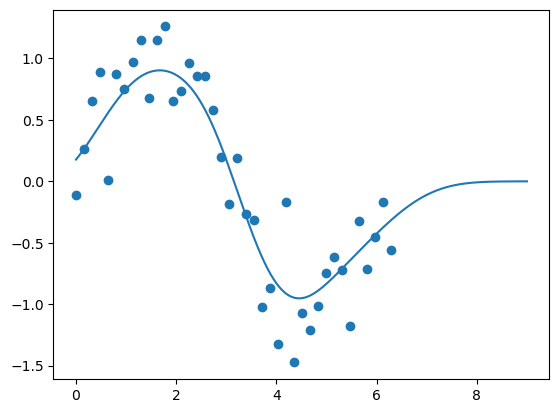

In [45]:
from sklearn.kernel_ridge import KernelRidge

x_max = 9.  # 予測の範囲の上限
# トレーニングデータ作成
n_tr = 40
x = np.linspace(0., np.pi*2., n_tr) # リスト 0から２πまでをn_tr等分した値を一次元配列
y = make_data_by_sin_gaussian(x)
X = x[:, np.newaxis]

kernel_ridge = KernelRidge(kernel="rbf") # 新しいのはこの部分(svrをこれに入れ替えるだけ)

# 学習を行う
kernel_ridge.fit(X, y)
  
# 回帰曲線を描く
x_test = np.linspace(0, x_max, 10000)
y_test = kernel_ridge.predict(x_test[:, np.newaxis])
    
#グラフにプロットする。
plt.scatter(x, y)
plt.plot(x_test, y_test)
plt.show()

## Relevance Vector Machine

SVMは様々なところで実用的に用いられているが、得られるのは識別や回帰の結果だけであり、予測に対する事後確率は計算できない。その点を改良する方法として関連ベクトルマシン（RVM: relevance vector machine)というのが考案されている。「疎なカーネルベースのベイズ流学習手法」であるとPRML7.2節に述べられている。

この方法はMicrosoftの特許であったが、2019/09に期限切れになった。それ以降、scikit-learnに実装された。興味があればそれも使ってみてほしい。

2023/07現在、anacondaの標準パッケージには入っていないが、sklearn-rvm (ver 0.1.1)はpipを使ってインストールできる。

- Wikipediaの解説 https://en.wikipedia.org/wiki/Relevance_vector_machine
- scikit-learnへの実装：sklern-rvm https://sklearn-rvm.readthedocs.io/en/latest/about.html ここにインストールの案内がある。
- PRMLの記述に沿った実装一例 https://qiita.com/ctgk/items/ee512530618a5eeccd1a




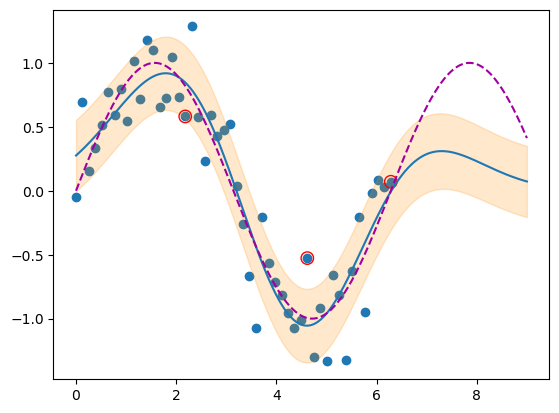

In [46]:
from sklearn_rvm import EMRVR
x_max = 9.  # 予測の範囲の上限

# トレーニングデータ作成
n_tr = 50
x = np.linspace(0., np.pi*2., n_tr) # リスト 0から２πまでをn_tr等分した値を一次元配列
y = make_data_by_sin_gaussian(x)
X = x[:, np.newaxis]
   
# 学習を行う
rvr = EMRVR(kernel='rbf', gamma="scale")
rvr.fit(X, y)
  
# テスト
x_test = np.linspace(0, x_max, 1000)
y_test, y_std = rvr.predict(x_test[:, np.newaxis], return_std=True) # standard dev. can be also obtained if "return_std" is set to be True
    
# plot prediction and the the width of std. dev.
plt.scatter(x, y)
plt.plot(x_test, y_test)
plt.fill_between(x_test, y_test - y_std, y_test + y_std, color="darkorange", alpha=0.2)


# show relevance vectors by red circles
relevance_vectors_idx = rvr.relevance_
plt.scatter(X[relevance_vectors_idx], y[relevance_vectors_idx], s=80, facecolors="none", edgecolors="r",
            label="relevance vectors")

# sin(x)
x_orig = np.linspace(0., x_max, 1000)
plt.plot(x_orig, np.sin(x_orig), color="#a000a0", linestyle="--")
plt.show()


色がついているのは、推定カーブ$\pm\sigma$の範囲であるから、分布がガウシアンであるとすると、この範囲は約68%に相当する。全データ数と帯内に入っているデータ数がそれくらいであることを確かめてみよう。

## 偏ったデータの場合

時間があれば、[サンプルページ](various_data4fitting.html)を参照しにあるような偏ったデータを作ってそれぞれの方法を試してみよう。


In [22]:
%%html
<link rel="stylesheet" type="text/css" href="custom.css">